# CS-GY 6953 Deep Learning Mini-Project First Attempt

Task: Building a ResNet model on CIFAR-10 with a constraint of 5 million parameters maximum.

## 1. Starting Simple: Load the CIFAR-10 dataset and build the first shallow ResNet network

Create the data loaders.

In [1]:
!pip install torchvision
!pip install torchsummary

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# There are more functions for augmentation.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Construct the ResNet.

In [4]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchsummary import summary

import os

In [5]:
class BasicBlock(nn.Module): # A residual block with 2 convolutional layers and a skip connection.
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,      # Number of channels in the input image
                               planes,         # Number of output channels
                               kernel_size=3,  # Size of the convolution filter
                               stride=stride,  # Stride of the convolution
                               padding=1,      # Padding added to all four sides of the input, int or {'valid', 'same'}, etc.
                               # padding_mode={'zeros', 'reflect', 'replicate', 'circular'}
                               bias=False)     # If true, adds a learnable bias ot the output.
        self.bn1 = nn.BatchNorm2d(planes)      # Other parameters include eps, momentum, affine, etc.
                                               # affine=True: affine parameters being learnable.
        self.conv2 = nn.Conv2d(planes, 
                               planes, 
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()        # A sequentil wrapper of layers.
        # If the dimentions of skip connection input and output don't match, do the following.
        # As an alternative solution, zero-padding is also proposed in the paper.
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, 
                                                    self.expansion*planes, 
                                                    kernel_size=1, 
                                                    stride=stride, 
                                                    bias=False),
                                          nn.BatchNorm2d(self.expansion*planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
model = ResNet(BasicBlock, [2,2,2,2])

In [8]:
summary(model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Note: No non-linearity in the fully connected part.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is {device}")
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

The device is cuda


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [28]:
def train(epoch):
    print('\nEpoch: %d'%epoch)
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    print(f"Train | Loss: {round(train_loss, 4)} | Acc: {round(acc, 2)}")
    train_losses.append(train_loss)
    train_accs.append(acc)

def test(epoch):
    global train_losses, test_losses, train_accs, test_accs, best_acc
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for (inputs, targets) in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    print(f"Test  | Loss: {round(test_loss, 4)} | Acc: {round(acc, 2)}")
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    state = {'model': model.state_dict(),
             'train_loss': train_losses,
             'test_loss': test_losses,
             'train_acc': train_accs,
             'test_acc': test_accs,
             'epoch': epoch}
    torch.save(state, './checkpoint/ckpt.pth')
    if acc > best_acc:
        torch.save(state, './checkpoint/ckpt_best.pth')
        best_acc = acc

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
state = {'model': model.state_dict(),
         'train_loss': [],
         'test_loss': [],
         'train_acc': [],
         'test_acc': [],
         'epoch': -1}
torch.save(state, './checkpoint/ckpt.pth')
torch.save(state, './checkpoint/ckpt_best.pth')

This model is ResNet34. With augmentation, the accuracy can get more than 90%.

In [ ]:
checkpoint = torch.load('./checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['model'])
train_losses = checkpoint['train_loss']
test_losses = checkpoint['test_loss']
train_accs = checkpoint['train_acc']
test_accs = checkpoint['test_acc']
best_acc = 0.0 if not test_accs else max(test_accs)
start_epoch = checkpoint['epoch']

for epoch in range(start_epoch + 1, start_epoch + 51):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 49
Train | Loss: 114.7033 | Acc: 90.15
Test  | Loss: 34.4563 | Acc: 85.86

Epoch: 50
Train | Loss: 113.7768 | Acc: 90.01
Test  | Loss: 35.7574 | Acc: 85.0

Epoch: 51
Train | Loss: 113.7538 | Acc: 90.03
Test  | Loss: 32.1731 | Acc: 86.57

Epoch: 52
Train | Loss: 113.0882 | Acc: 90.17
Test  | Loss: 36.5142 | Acc: 84.48

Epoch: 53
Train | Loss: 110.2807 | Acc: 90.43
Test  | Loss: 37.8596 | Acc: 84.02

Epoch: 54
Train | Loss: 111.8164 | Acc: 90.22
Test  | Loss: 41.6646 | Acc: 83.56

Epoch: 55
Train | Loss: 111.8564 | Acc: 90.09
Test  | Loss: 40.2985 | Acc: 84.7

Epoch: 56
Train | Loss: 107.7752 | Acc: 90.58
Test  | Loss: 29.4375 | Acc: 87.7

Epoch: 57
Train | Loss: 108.0076 | Acc: 90.59
Test  | Loss: 34.6377 | Acc: 85.5

Epoch: 58
Train | Loss: 109.5656 | Acc: 90.47
Test  | Loss: 38.563 | Acc: 84.22

Epoch: 59
Train | Loss: 108.2253 | Acc: 90.55
Test  | Loss: 34.5467 | Acc: 85.83

Epoch: 60
Train | Loss: 107.0668 | Acc: 90.67
Test  | Loss: 35.0936 | Acc: 85.98

Epoch: 61
Train | Lo

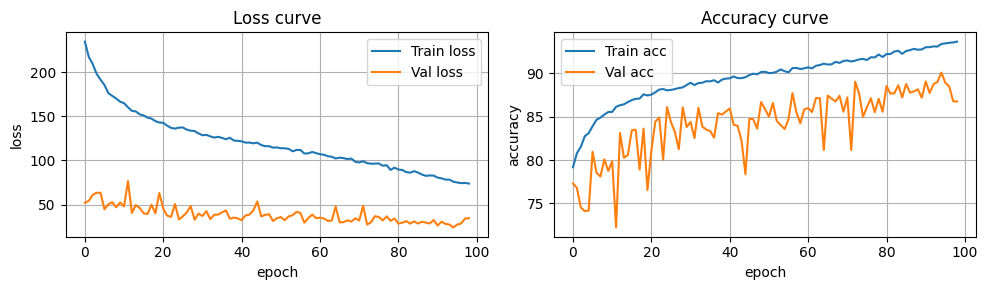

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,3))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label = 'Train loss')
plt.plot(range(len(test_losses)), test_losses, label = 'Val loss')
plt.title('Loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_accs, label = 'Train acc')
plt.plot(range(len(test_losses)), test_accs, label = 'Val acc')
plt.title('Accuracy curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

The loss should have divided by the number of samples...